In [47]:
# Bibliotecas utilizadas no notebook, tenha certeza de que estão instaladas

import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import stats

# QUESTÃO 2 - A/B:

a) Definir as segmentações que fazem sentido especificamente para o teste A/B que está analisando. <br>

b) Estabelecer quais serão os critérios utilizados para cada segmento sugerido no item a). Utilize os critérios/ferramentas que achar necessários, mas lembre-se de explicar o racional utilizado na criação.

**1. Plataforma de origem do usuário**

**Categorias:** 'ANDROID', 'DESKTOP', 'IOS', 'WINDOWS_PHONE'

Segmentar pela plataforma de origem é relevante, pois cada uma apresenta características e comportamentos distintos. Usuários de dispositivos móveis (Android e IOS) tendem a interagir de forma diferente dos usuários de desktop, geralmente buscando experiências mais rápidas e simples. Já no desktop, é possível oferecer interações mais complexas. Compreender as métricas de retenção por plataforma permite criar campanhas e estratégias de marketing personalizadas, além de identificar tendências de crescimento ou abandono em cada plataforma.

**2. Cidade/Estado**

Segmentar por cidade, mais especificamente por sua densidade populacional pode fazer sentido pois cidades com maior volume populacional indica que há uma maior concentração de restaurantes, lojas e opções de entregas, além da logística ser mais eficiente, o que pode aumentar a competição entre os estabelecimentos e necessitar de estratégias específicas para essas cidades enquanto cidades com menor número de habitantes, o usuário pode valorizar descontos maiores visto que provavemente não existem tantas opções.

Além disso, devido ao tamanho do Brasil, o país se caracteriza por uma grande diversidade cultural entre seus estados, com costumes e comportamentos de consumo variados. O que é valorizado em uma cidade pode ser completamente diferente em outra. Por exemplo, em algumas regiões, o foco pode ser em descontos rápidos, enquanto em outras, os consumidores podem valorizar ofertas sazonais ou promoções de fidelidade. Portanto, essas diferenças culturais devem ser consideradas ao planejar as estratégias de ofertas de cupons.

**3. Faixa de gasto**

A segmentação por faixa de gasto permite identificar diferentes padrões de comportamento: alguns usuários gastam muito em poucas compras, outros fazem várias compras pequenas. Com isso, é possível criar estratégias de cupons e incentivos adequados para manter cada perfil engajado ao longo do tempo, explorando oportunidades específicas para cada segmento.

**4. Segmentação por Tipo de Cliente (Novo vs. Recorrente)**

A segmentação por tipo de cliente é crucial para otimizar a campanha de cupons, pois clientes novos respondem melhor a descontos maiores para atrair a primeira compra, enquanto clientes recorrentes são mais sensíveis a descontos menores e benefícios exclusivos, como frete grátis, para incentivar compras repetidas e fidelização. Essa abordagem personalizada maximiza a eficiência das estratégias de marketing, ajustando as ofertas conforme o comportamento de cada grupo.

# QUESTÃO 2 - C:

Analisar os resultados do teste A/B com base nos segmentos definidos nos itens a) e b).

## 1. Plataforma de origem do usuário

### Importando dados

In [48]:
df = pd.read_csv('orders_origin_platform.csv')

In [49]:
unique_users_per_platform = df.groupby('origin_platform')['customer_id'].nunique()
print(unique_users_per_platform)

origin_platform
ANDROID          359516
DESKTOP          136634
IOS              348439
WINDOWS_PHONE      8128
Name: customer_id, dtype: int64


In [50]:
# Encontrar o menor número de usuários únicos entre as plataformas
min_users = unique_users_per_platform.min()

# Selecionar os primeiros 'min_users' usuários únicos de cada plataforma
filtered_dfs = []  # Lista para armazenar os dataframes filtrados de cada plataforma
for platform in df['origin_platform'].unique():  # Itera sobre cada plataforma única
    users = df[df['origin_platform'] == platform]['customer_id'].unique()[:min_users]  # Seleciona os primeiros 'min_users' usuários únicos dessa plataforma
    filtered = df[df['origin_platform'] == platform]  # Filtra o dataframe para a plataforma atual
    filtered = filtered[filtered['customer_id'].isin(users)]  # Mantém apenas as linhas dos usuários selecionados
    filtered_dfs.append(filtered)  # Adiciona o dataframe filtrado à lista

df_balanced = pd.concat(filtered_dfs, ignore_index=True)

In [51]:
# Contagem de linhas para cada valor de origin_platform
platform_counts = df_balanced['origin_platform'].value_counts()
print(platform_counts)

# Contagem valores únicos de customer_id para cada origin_platform
platform_customer_counts = df_balanced.groupby('origin_platform')['customer_id'].nunique()
print(platform_customer_counts)

origin_platform
IOS              87446
DESKTOP          79566
ANDROID          75551
WINDOWS_PHONE    27876
Name: count, dtype: int64
origin_platform
ANDROID          8127
DESKTOP          8127
IOS              8127
WINDOWS_PHONE    8127
Name: customer_id, dtype: int64


### Indicador 1: Qtd média de pedidos por usuário único por Plataforma

In [52]:
# Calcular a quantidade de pedidos por customer_id em cada plataforma
pedidos_por_usuario_plataforma = df_balanced.groupby(['origin_platform', 'customer_id']).size()

# Calcular a média de pedidos por usuário para cada plataforma
media_pedidos_por_customer_id = pedidos_por_usuario_plataforma.groupby('origin_platform').mean()

for plataforma, media in media_pedidos_por_customer_id.sort_values(ascending=False).items():
    print(f"Média de pedidos por usuário na plataforma {plataforma}: {media:.2f}")

Média de pedidos por usuário na plataforma IOS: 10.39
Média de pedidos por usuário na plataforma DESKTOP: 9.52
Média de pedidos por usuário na plataforma ANDROID: 8.90
Média de pedidos por usuário na plataforma WINDOWS_PHONE: 3.42


### Indicador 2: Soma do valor total dos pedidos por plataforma

In [53]:
soma_valor_total_por_plataforma = df_balanced.groupby('origin_platform')['order_total_amount'].sum()

for platform, total in soma_valor_total_por_plataforma.sort_values(ascending=False).items():
    print(f"Soma do valor total dos pedidos por plataforma {platform}: R$ {total:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

Soma do valor total dos pedidos por plataforma IOS: R$ 4.621.272,78
Soma do valor total dos pedidos por plataforma DESKTOP: R$ 3.665.449,82
Soma do valor total dos pedidos por plataforma ANDROID: R$ 3.502.807,57
Soma do valor total dos pedidos por plataforma WINDOWS_PHONE: R$ 1.120.142,38


### Indicador 3: Valor médio gasto por usuário único em cada plataforma

In [54]:
# Calcular o valor médio gasto por customer_id em cada plataforma
valor_medio_gasto_por_usuario_plataforma = df.groupby(['origin_platform', 'customer_id'])['order_total_amount'].sum().groupby('origin_platform').mean()

for plataforma, valor in valor_medio_gasto_por_usuario_plataforma.sort_values(ascending=False).items():
    print(f"{plataforma}: R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

IOS: R$ 244,78
DESKTOP: R$ 184,96
ANDROID: R$ 176,35
WINDOWS_PHONE: R$ 137,28


### Teste de Hipóteses
Hipótese nula (H₀): Não há diferença significativa no total de gastos entre as plataformas. Ou seja, as plataformas não impactam no comportamento de gastos.

Hipótese alternativa (H₁): Há uma diferença significativa no total de gastos entre as plataformas. Ou seja, as plataformas impactam no comportamento de gastos.

In [55]:
from scipy import stats

# Extrair dados para cada plataforma
android_data = df[df['origin_platform'] == 'ANDROID']['order_total_amount']
ios_data = df[df['origin_platform'] == 'IOS']['order_total_amount']
desktop_data = df[df['origin_platform'] == 'DESKTOP']['order_total_amount']
windows_phone_data = df[df['origin_platform'] == 'WINDOWS_PHONE']['order_total_amount']

# Realizando a ANOVA
f_stat, p_value = stats.f_oneway(android_data, ios_data, desktop_data, windows_phone_data)

# Exibindo o resultado do teste
print(f"Estatísticas de ANOVA: F-stat = {f_stat:.4f}, p-value = {p_value:.4f}")

# Resultado
if p_value < 0.05:
    print(f"A diferença entre as plataformas é estatisticamente significativa (p-value = {p_value:.4f})")
else:
    print(f"A diferença entre as plataformas não é estatisticamente significativa (p-value = {p_value:.4f})")

print("A diferença entre as plataformas (Android, iOS, Desktop, Windows Phone) é estatisticamente significativa. Isso significa que o tipo de plataforma tem um impacto no comportamento observado (como o valor total dos pedidos).")

Estatísticas de ANOVA: F-stat = 1630.7966, p-value = 0.0000
A diferença entre as plataformas é estatisticamente significativa (p-value = 0.0000)
A diferença entre as plataformas (Android, iOS, Desktop, Windows Phone) é estatisticamente significativa. Isso significa que o tipo de plataforma tem um impacto no comportamento observado (como o valor total dos pedidos).


## 2. Cidade/Estado

### Importando dados

In [41]:
df1 = pd.read_csv('orders_delivery_address_city.csv')

In [42]:
# Carregar o arquivo CSV com as cidades e estados e adicionar os estados ao DataFrame principal
cidades_estados = pd.read_csv('cidades_estados.csv')
df2 = df1.merge(cidades_estados, left_on='delivery_address_city', right_on='Cidade', how='left')
df = df2.drop(columns=['Cidade'])

### Indicador 1: Qtd média de pedidos por usuário único por Cidade/Estado

In [43]:
# Calcular a quantidade de pedidos por customer_id em cada estado
pedidos_por_usuario_estado = df.groupby(['Estado', 'customer_id']).size()

# Calcular a média de pedidos por usuário para cada estado
media_pedidos_por_customer_id_estado = pedidos_por_usuario_estado.groupby('Estado').mean()

for estado, media in media_pedidos_por_customer_id_estado.sort_values(ascending=False).head(100).items():
    print(f"Média de pedidos por usuário no estado {estado}: {media:.2f}")

Média de pedidos por usuário no estado CE: 5.67
Média de pedidos por usuário no estado RJ: 4.98
Média de pedidos por usuário no estado DF: 4.47
Média de pedidos por usuário no estado ES: 4.43
Média de pedidos por usuário no estado MS: 4.42
Média de pedidos por usuário no estado PE: 4.40
Média de pedidos por usuário no estado SP: 4.39
Média de pedidos por usuário no estado PB: 4.32
Média de pedidos por usuário no estado AM: 4.31
Média de pedidos por usuário no estado RS: 4.29
Média de pedidos por usuário no estado PR: 4.11
Média de pedidos por usuário no estado RN: 4.09
Média de pedidos por usuário no estado PA: 4.02
Média de pedidos por usuário no estado MG: 3.87
Média de pedidos por usuário no estado BA: 3.81
Média de pedidos por usuário no estado MA: 3.62
Média de pedidos por usuário no estado GO: 3.58
Média de pedidos por usuário no estado SC: 2.70


In [6]:
# Calcular a quantidade de pedidos por customer_id em cada cidade
pedidos_por_usuario_plataforma = df.groupby(['delivery_address_city', 'customer_id']).size()

# Calcular a média de pedidos por usuário para cada cidade
media_pedidos_por_customer_id = pedidos_por_usuario_plataforma.groupby('delivery_address_city').mean()

for cidade, media in media_pedidos_por_customer_id.sort_values(ascending=False).head(10).items():
    print(f"Média de pedidos por usuário na cidade {cidade}: {media:.2f}")

Média de pedidos por usuário na cidade FORTALEZA: 5.67
Média de pedidos por usuário na cidade JUIZ DE FORA: 5.19
Média de pedidos por usuário na cidade LONDRINA: 5.01
Média de pedidos por usuário na cidade BAURU: 4.96
Média de pedidos por usuário na cidade RIO DE JANEIRO: 4.96
Média de pedidos por usuário na cidade SANTOS: 4.92
Média de pedidos por usuário na cidade NITEROI: 4.89
Média de pedidos por usuário na cidade VITORIA: 4.82
Média de pedidos por usuário na cidade MARILIA: 4.74
Média de pedidos por usuário na cidade JOAO PESSOA: 4.72


In [ ]:
# Calcular a média de pedidos por usuário para as 10 cidades com menor média
for cidade, media in media_pedidos_por_customer_id.sort_values(ascending=False).tail(10).items():
    print(f"Média de pedidos por usuário na cidade {cidade}: {media:.2f}")

Média de pedidos por usuário na cidade JAPERI: 1.00
Média de pedidos por usuário na cidade JUAZEIRO: 1.00
Média de pedidos por usuário na cidade ITABORAI: 1.00
Média de pedidos por usuário na cidade NOSSA SENHORA DO SOCORRO: 1.00
Média de pedidos por usuário na cidade FRANCISCO MORATO: 1.00
Média de pedidos por usuário na cidade GUARATINGUETA: 1.00
Média de pedidos por usuário na cidade SALTO: 1.00
Média de pedidos por usuário na cidade SEROPEDICA: 1.00
Média de pedidos por usuário na cidade SAPUCAIA DO SUL: 1.00
Média de pedidos por usuário na cidade VARGINHA: 1.00


### Indicador 2: Soma do valor total dos pedidos por Cidade/Estado

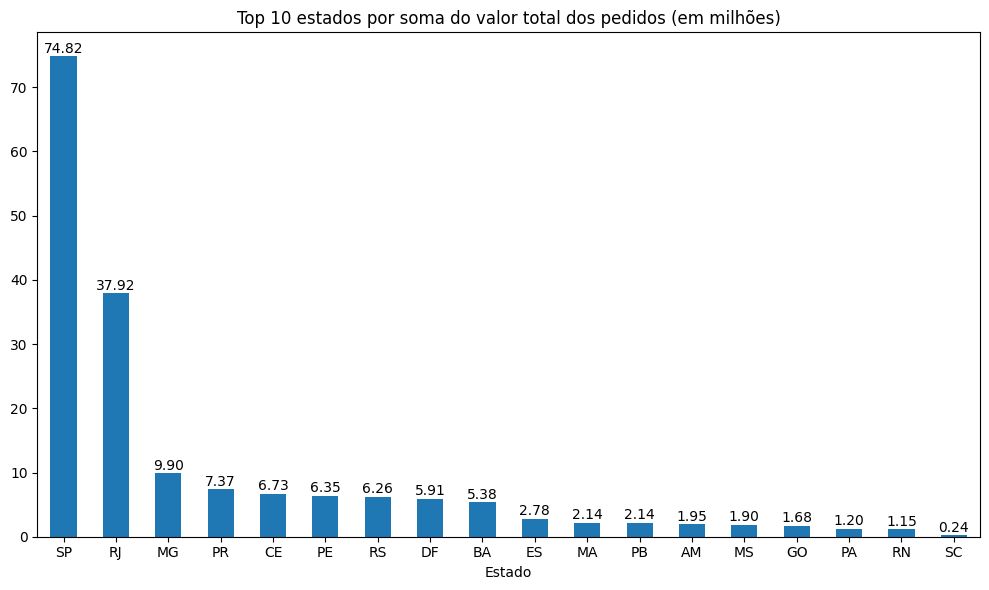

In [37]:
# Soma do valor total dos pedidos por estado
soma_valor_total_por_estado = df.groupby('Estado')['order_total_amount'].sum()

# Converter os valores para milhões
soma_milhoes_estado = soma_valor_total_por_estado / 1_000_000

# Selecionar os 10 estados com maior soma
top_estados = soma_milhoes_estado.sort_values(ascending=False).head(100)

plt.figure(figsize=(10, 6))
ax = top_estados.plot(kind='bar')
plt.ylabel('')  # Remove o eixo y
plt.xlabel('Estado')
plt.title('Top 10 estados por soma do valor total dos pedidos (em milhões)')

# Adiciona o valor em cima de cada barra
for i, v in enumerate(top_estados):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Criar uma tabela com os top 10 estados que mais gastaram (em milhões)
top_estados_tabela = top_estados.reset_index()
top_estados_tabela.columns = ['Estado', 'Total gasto (milhões R$)']
top_estados_tabela['Total gasto (milhões R$)'] = top_estados_tabela['Total gasto (milhões R$)'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

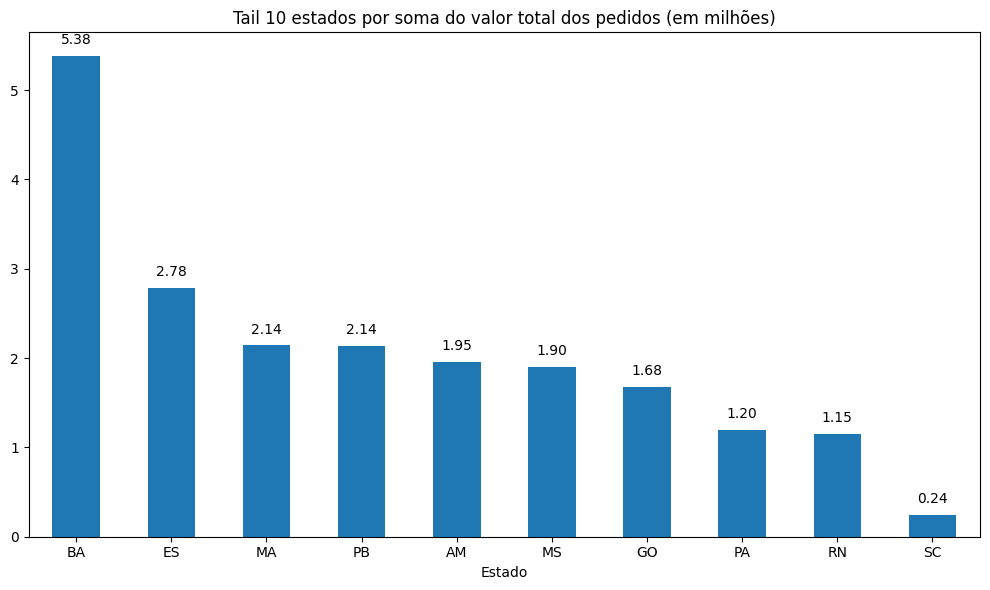

In [ ]:
# Soma do valor total dos pedidos por estado
soma_valor_total_por_estado = df.groupby('Estado')['order_total_amount'].sum()

# Converter os valores para milhões
soma_milhoes_estado = soma_valor_total_por_estado / 1_000_000

# Selecionar os 10 estados com maior soma
top_estados = soma_milhoes_estado.sort_values(ascending=False).tail(10)

plt.figure(figsize=(10, 6))
ax = top_estados.plot(kind='bar')
plt.ylabel('')  # Remove o eixo y
plt.xlabel('Estado')
plt.title('Last 10 estados por soma do valor total dos pedidos (em milhões)')

# Adiciona o valor em cima de cada barra
for i, v in enumerate(top_estados):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Criar uma tabela com os top 10 estados que mais gastaram (em milhões)
top_estados_tabela = top_estados.reset_index()
top_estados_tabela.columns = ['Estado', 'Total gasto (milhões R$)']
top_estados_tabela['Total gasto (milhões R$)'] = top_estados_tabela['Total gasto (milhões R$)'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

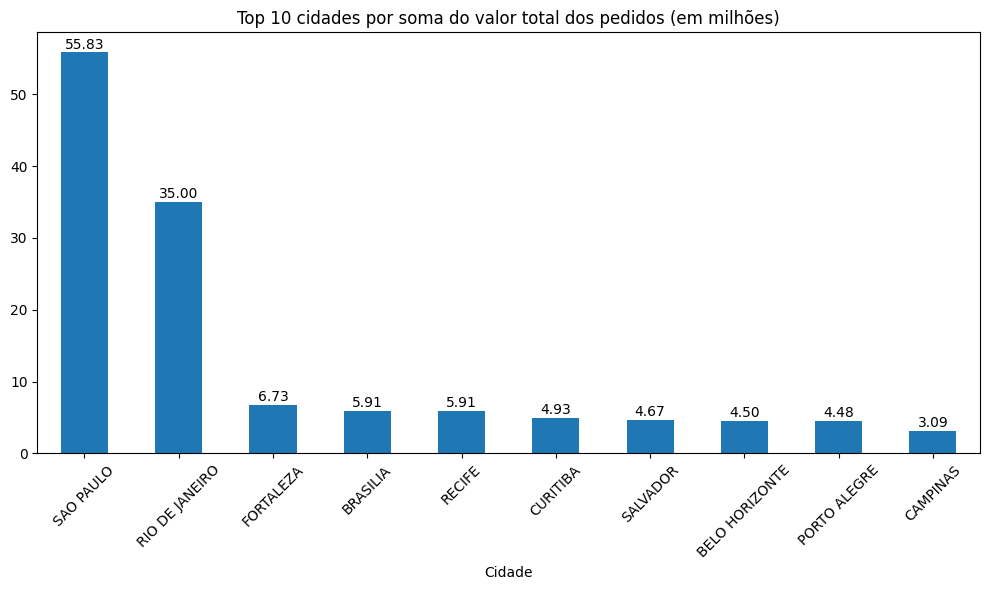

In [ ]:
soma_valor_total_por_cidade = df.groupby('delivery_address_city')['order_total_amount'].sum()

import matplotlib.pyplot as plt

# Converter os valores para milhões
soma_milhoes = soma_valor_total_por_cidade / 1_000_000

# Selecionar as 10 cidades com maior soma
top_cidades = soma_milhoes.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = top_cidades.plot(kind='bar')
plt.ylabel('')  # Remove o eixo y
plt.xlabel('Cidade')
plt.title('Top 10 cidades por soma do valor total dos pedidos (em milhões)')

# Adiciona o valor em cima de cada barra
for i, v in enumerate(top_cidades):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

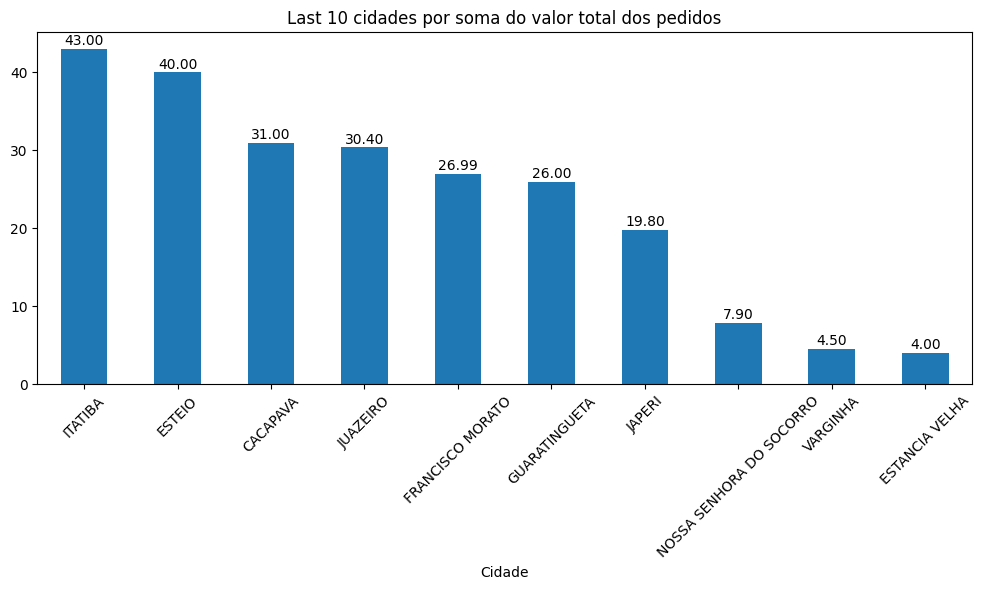

In [46]:
soma_valor_total_por_cidade = df.groupby('delivery_address_city')['order_total_amount'].sum()

import matplotlib.pyplot as plt

# Converter os valores para milhões
soma_milhoes = soma_valor_total_por_cidade

# Selecionar as 10 cidades com maior soma
top_cidades = soma_milhoes.sort_values(ascending=False).tail(10)

plt.figure(figsize=(10, 6))
ax = top_cidades.plot(kind='bar')
plt.ylabel('')  # Remove o eixo y
plt.xlabel('Cidade')
plt.title('Last 10 cidades por soma do valor total dos pedidos')

# Adiciona o valor em cima de cada barra
for i, v in enumerate(top_cidades):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Indicador 3: Valor médio gasto por usuário em cada Cidade/Estado

In [40]:
# Calcular o gasto total por usuário em cada estado
gasto_por_usuario_estado = df.groupby(['Estado', 'customer_id'])['order_total_amount'].sum()

# Calcular o valor médio de gasto por usuário em cada estado
valor_medio_gasto_por_usuario_estado = gasto_por_usuario_estado.groupby('Estado').mean()

# Exibir os 10 estados com maior valor médio de gasto por usuário, formatando em R$ pt-BR
top_10_estados = valor_medio_gasto_por_usuario_estado.sort_values(ascending=False)
for estado, valor in top_10_estados.items():
    print(f"{estado}: R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

RJ: R$ 262,39
SP: R$ 226,70
CE: R$ 222,68
DF: R$ 199,75
PE: R$ 198,08
BA: R$ 197,36
AM: R$ 192,04
PA: R$ 187,49
RS: R$ 181,10
MS: R$ 178,77
ES: R$ 172,70
PR: R$ 169,82
PB: R$ 167,73
RN: R$ 162,40
MA: R$ 152,44
MG: R$ 146,16
GO: R$ 140,72
SC: R$ 138,06


In [ ]:
# Calcular o gasto total por usuário em cada cidade
gasto_por_usuario_cidade = df.groupby(['delivery_address_city', 'customer_id'])['order_total_amount'].sum()

# Calcular o valor médio de gasto por usuário em cada cidade
valor_medio_gasto_por_usuario_cidade = gasto_por_usuario_cidade.groupby('delivery_address_city').mean()

# Exibir as 10 cidades com maior valor médio de gasto por usuário, formatando em R$ pt-BR
top_10 = valor_medio_gasto_por_usuario_cidade.sort_values(ascending=False).head(10)
for cidade, valor in top_10.items():
    print(f"{cidade}: R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

# Temos um outliers na cidade de Itajai.


ITAJAI: R$ 2.816,88
FORMOSA: R$ 283,68
SANTANA DE PARNAIBA: R$ 267,61
RIO DE JANEIRO: R$ 263,24
JACAREI: R$ 257,20
SAO PAULO: R$ 250,83
NITEROI: R$ 235,90
SANTOS: R$ 231,06
FORTALEZA: R$ 222,68
RECIFE: R$ 204,11
SALVADOR: R$ 200,21


### Teste de Hipóteses

Hipótese nula (H₀): Não há diferença significativa no total de gastos entre as cidades/estados. Ou seja, a cidade/estado não impacta o comportamento de gastos dos usuários.

Hipótese alternativa (H₁): Há uma diferença significativa no total de gastos entre as cidades/estados. Ou seja, a cidade/estado impacta o comportamento de gastos dos usuários.

In [32]:
from scipy import stats

# Selecionar os 10 estados com maior soma do valor total dos pedidos
top_estados_nomes = top_estados.index

# Criar listas de valores de pedidos para cada estado do top 10
estado_data = [df[df['Estado'] == estado]['order_total_amount'] for estado in top_estados_nomes]

# Realizar o teste de ANOVA
f_stat, p_value = stats.f_oneway(*estado_data)

print(f"Estatísticas de ANOVA: F-stat = {f_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print(f"A diferença entre os estados é estatisticamente significativa (p-value = {p_value:.4f})")
else:
    print(f"A diferença entre os estados não é estatisticamente significativa (p-value = {p_value:.4f})")


Estatísticas de ANOVA: F-stat = 698.9630, p-value = 0.0000
A diferença entre os estados é estatisticamente significativa (p-value = 0.0000)


## 3. Faixas de gasto

### Importando dados

In [ ]:
df = pd.read_csv('orders_origin_platform.csv')

In [ ]:
# Contagem total de customer_id e customer_id únicos para entender  a distribuição dos clientes
total_customer_id = df['customer_id'].count()
unique_customer_id = df['customer_id'].nunique()

print(f"Total de customer_id: {total_customer_id}")
print(f"Total de customer_id únicos: {unique_customer_id}")

Total de customer_id: 3662321
Total de customer_id únicos: 806466


In [3]:
# Análise de gasto por usuário

# Definindo faixas de gasto (em reais)
bins = [0, 100, 300, 600, 1000, float('inf')]
labels = ['Até R$100', 'R$100-300', 'R$300-600', 'R$600-1000', 'Acima de R$1000']

# Calcular o gasto total por usuário
gasto_por_usuario = df.groupby('customer_id')['order_total_amount'].sum()

# Categorizar cada usuário em uma faixa de gasto
faixas = pd.cut(gasto_por_usuario, bins=bins, labels=labels, right=False)

# Contar o número de customer_id únicos por faixa de gasto
unique_customers_per_faixa = faixas.value_counts().sort_index()
print(unique_customers_per_faixa)
print("Somatório total de usuários:", unique_customers_per_faixa.sum())

order_total_amount
Até R$100          370285
R$100-300          277182
R$300-600           99572
R$600-1000          36878
Acima de R$1000     22549
Name: count, dtype: int64
Somatório total de usuários: 806466


In [4]:
# Adicionando a coluna de faixa de gastos ao dataframe original
df['faixa_gastos'] = pd.cut(df['order_total_amount'], bins=bins, labels=labels, right=False)

### Indicador 1: Qtd média de pedidos por usuário único por Faixa de gasto

In [38]:
media_pedidos_por_faixa = df.groupby('faixa_gastos')['customer_id'].count() / df.groupby('faixa_gastos')['customer_id'].nunique()

for faixa, media in media_pedidos_por_faixa.sort_values(ascending=False).items():
    print(f"Média de pedidos por usuário na faixa {faixa}: {media:.2f}")

C:\Users\gusta\AppData\Local\Temp\ipykernel_17064\2766549346.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_pedidos_por_faixa = df.groupby('faixa_gastos')['customer_id'].count() / df.groupby('faixa_gastos')['customer_id'].nunique()


Média de pedidos por usuário na faixa Até R$100: 4.41
Média de pedidos por usuário na faixa R$100-300: 2.47
Média de pedidos por usuário na faixa R$300-600: 1.92
Média de pedidos por usuário na faixa Acima de R$1000: 1.72
Média de pedidos por usuário na faixa R$600-1000: 1.63


### Indicador 2: Soma do valor total dos pedidos por faixa de gasto

In [39]:
soma_valor_total_por_faixa = df.groupby('faixa_gastos')['order_total_amount'].sum()
for faixa, total in soma_valor_total_por_faixa.items():
    percentual = (total / soma_valor_total_por_faixa.sum()) * 100
    print(f"Soma valor total {faixa}: R$ {total:,.2f} ({percentual:.2f}%)".replace(",", "X").replace(".", ",").replace("X", "."))


Soma valor total Até R$100: R$ 142.081.691,33 (80,81%)
Soma valor total R$100-300: R$ 30.994.490,06 (17,63%)
Soma valor total R$300-600: R$ 1.851.003,67 (1,05%)
Soma valor total R$600-1000: R$ 188.426,69 (0,11%)
Soma valor total Acima de R$1000: R$ 717.156,10 (0,41%)


C:\Users\gusta\AppData\Local\Temp\ipykernel_17064\1272090740.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  soma_valor_total_por_faixa = df.groupby('faixa_gastos')['order_total_amount'].sum()


### Indicador 3: Valor médio por faixa de gasto

In [43]:
# Lista dos valores gastos por usuário em cada faixa
valores_por_faixa = df.groupby('faixa_gastos')['order_total_amount'].apply(list)

# Média dos valores gastos por usuário em cada faixa
media_valores_por_faixa = valores_por_faixa.apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

resultado_formatado = media_valores_por_faixa.reset_index()
resultado_formatado.columns = ['faixa_gastos', 'valor médio']
resultado_formatado['valor médio'] = resultado_formatado['valor médio'].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
print(resultado_formatado)


C:\Users\gusta\AppData\Local\Temp\ipykernel_17064\744599360.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valores_por_faixa = df.groupby('faixa_gastos')['order_total_amount'].apply(list)


      faixa_gastos  valor médio
0        Até R$100     R$ 41,29
1        R$100-300    R$ 137,96
2        R$300-600    R$ 375,61
3       R$600-1000    R$ 724,72
4  Acima de R$1000  R$ 6.765,62


### Teste de Hipóteses

Hipótese nula (H₀): Não há diferença significativa no total de gastos entre as faixas de gasto. Ou seja, a faixa de gasto não impacta o comportamento de gastos dos usuários.

Hipótese alternativa (H₁): Há uma diferença significativa no total de gastos entre as faixas de gasto. Ou seja, a faixa de gasto impacta o comportamento de gastos dos usuários.

In [45]:
from scipy import stats

# Agrupar os dados pelas faixas e obter os dados de gasto total
faixas_gasto = df.groupby(faixas)['order_total_amount'].sum()

# Criar as listas de dados para cada faixa
faixa_data = [df[df['faixa_gastos'] == faixa]['order_total_amount'] for faixa in labels]

# Realizar o teste de ANOVA
f_stat, p_value = stats.f_oneway(*faixa_data)

# Exibir os resultados do teste
print(f"Estatísticas de ANOVA: F-stat = {f_stat:.4f}, p-value = {p_value:.4f}")

# Resultado
if p_value < 0.05:
    print(f"A diferença entre as plataformas é estatisticamente significativa (p-value = {p_value:.4f})")
else:
    print(f"A diferença entre as plataformas não é estatisticamente significativa (p-value = {p_value:.4f})")

print("A diferença entre as faixas de gasto é estatisticamente significativa, ou seja, a faixa de gasto que o usuário se encontra tem um impacto no comportamento observado (como o valor total dos pedidos).")


C:\Users\gusta\AppData\Local\Temp\ipykernel_17064\1244182478.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faixas_gasto = df.groupby(faixas)['order_total_amount'].sum()


Estatísticas de ANOVA: F-stat = 150434.4802, p-value = 0.0000
A diferença entre as plataformas é estatisticamente significativa (p-value = 0.0000)
A diferença entre as faixas de gasto é estatisticamente significativa, ou seja, a faixa de gasto que o usuário se encontra tem um impacto no comportamento observado (como o valor total dos pedidos).
